In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.stats import norm

#split the data into intervals (bins). calculates IV, WOE for each bin
import optbinning  


import sklearn
from sklearn import metrics 
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

#Regression
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, LogisticRegression, LogisticRegressionCV

#Classification/clustering
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import NearestNeighbors, KNeighborsRegressor
from sklearn.cluster import DBSCAN, KMeans

#Imbalanced data classification
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier, RUSBoostClassifier
from imblearn.over_sampling import SMOTE, BorderlineSMOTE





df =  pd.read_csv("data/treino.csv")

sns.set(rc={'figure.figsize':(7,5)})

In [2]:
def log1(x):
    return np.log(1+x)

def cap_outliers(df,lower,upper):
    #capping outliers
    return np.where(df > upper, upper, np.where(df < lower, lower, df))

def drop_outliers_IQR(df,var_name,target_class = None):
    q1=df[var_name].quantile(0.25)
    q3=df[var_name].quantile(0.75)

    IQR=q3-q1
    outliers = df[((df[var_name]<(q1-1.5*IQR)) | (df[var_name]>(q3+1.5*IQR)))]
    
    if (target_class in df):
        neg, pos = np.bincount(outliers[target_class])
        total = neg + pos
        print('Total outliers: {}\n    {}: {} ({:.2f}% of total outliers)\n'.format(
            total,target_class, pos, 100 * pos / total))
        print("total removed outliers: ",len(outliers), "= ", len(outliers)/len(df) * 100,"% of all data")
    
    
    
    not_outliers = df[~((df[var_name]<(q1-1.5*IQR)) | (df[var_name]>(q3+1.5*IQR)))]

    #outliers_dropped = not_outliers.reset_index()

    return not_outliers

def drop_outliers_zscore(df,var_name,target_class = None):
    m = df[var_name].mean()
    std = df[var_name].std()
    outliers = df[(df[var_name] > (m + 3*std)) | (df[var_name] < (m - 3*std))]
    
    if (target_class in df):
        neg, pos = np.bincount(outliers[target_class])
        total = neg + pos
        print('Total outliers: {}\n    {}: {} ({:.2f}% of total outliers)\n'.format(
            total,target_class, pos, 100 * pos / total))
        print("total removed outliers: ",len(outliers), "= ", len(outliers)/len(df) * 100,"% of all data")
    
    not_outliers = df[~((df[var_name] > (m + 3*std)) | (df[var_name] < (m - 3*std)))]

    #outliers_dropped = not_outliers.reset_index()
    
    return not_outliers

def plot_histogram(dataf , dofit=False):
    # Fit a normal distribution to the data:


    q25, q75 = np.nanpercentile(dataf, [25, 75])
    bin_width = 2 * (q75 - q25) * len(dataf.dropna()) ** (-1/3)
    bins = round((dataf.dropna().max() - dataf.dropna().min()) / bin_width)
    bins = min(bins,200)
    # Plot the histogram.
    plt.hist(dataf, bins=bins, density=True, alpha=1, color='g')

    # Plot the PDF.
    if dofit: 
        mu, std = norm.fit(dataf.dropna())
        xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu, std)

        plt.plot(x, p, 'k', linewidth=2)
        title = "Fit results: mean = %.4f,  std = %.4f" % (mu, std)
        plt.title(title)

    
    
    


In [3]:
df

,inadimplente,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
109995,0,0.137396,59,1,0.448912,9600.0,10,0,2,0,0.0
109996,0,0.276964,46,0,0.491288,12224.0,19,0,4,0,4.0
109997,0,0.181257,43,0,0.382635,12000.0,13,0,2,0,2.0
109998,0,0.037699,86,0,0.248107,7000.0,14,0,2,0,1.0


<ul>
<li>idade: A idade do cliente</li>
<li>numero_de_dependentes: O número de pessoas dependentes do cliente.</li>
<li>salario_mensal: Salário mensal do cliente.</li>
<li>numero_emprestimos_imobiliarios: Quantidade de empréstimos imobiliários que o
cliente possui em aberto.</li>
<li>util_linhas_inseguras: Quanto que o cliente está usando, relativamente ao limite
dele, de linhas de crédito que não são seguradas por qualquer bem do tomador
e.g: imoveis, carros etc.</li>
<li>razao_debito: Razão entre as dívidas e o patrimônio do tomador. razão débito =
Dividas/Patrimônio</li>
<li>numero_linhas_crdto_aberto: Número de empréstimos em aberto pelo cliente.</li>
<li>vezes_passou_de_30_59_dias: Número de vezes que o cliente atrasou, entre 30
e 59 dias, o pagamento de um empréstimo.</li>
<li>numero_de_vezes_que_passou_60_89_dias: Número de vezes que o cliente
atrasou, entre 60 e 89 dias, o pagamento de um empréstimo.</li>
<li>numero_vezes_passou_90_dias: Número de vezes que o tomador passou mais
de 90 dias em atraso.</li>
</ul>

# Problem Challenges

## 1) Imbalanced Data Treatment:

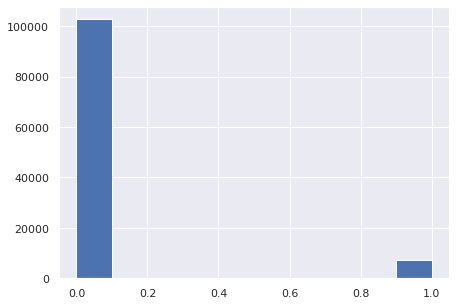

In [4]:
df["inadimplente"].hist();

In [5]:
neg, pos = np.bincount(df['inadimplente'])
total = neg + pos
print('Examples:\n    Total: {}\n    inadimplente: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))


Examples:
    Total: 110000
    inadimplente: 7331 (6.66% of total)



#### Solving imbalance in data:

<ul>
    <li> Raw Data Treatment 
        <ul>
          <li>Oversampling: creating new instances of the minority class: SMOTE (Synthetic Minority Oversampling Technique)</li>
          <li>Undersampling: deleting instances of the majority class</li>
        </ul>
    </li>
    <li> Training strategies
    <ul>
        <li>
            Class weights: add different wights to the classes so the smaller class has a higher weight on the cost function  
        </li>
          <li>Bagging (Bootstrap Aggregating):  different training datasets are generated by random sampling with replacement from the original dataset, so some observations may be repeated in different datasets. These new sets are used to train the same learner algorithm and different classifiers are produced. <b>Different learners are trained independently and in parallel</b>. Then the predictions are obtained by averaging the results of all the learners.</li>
          <li>Boosting: different training datasets are generated by random sampling with replacement. <b>Each classifier considers the previous classifiers’ success: samples that are misclassified get higher weight</b>, so the different models are trained sequentially and adaptively. The final vote is obtained considering the weighted average of the estimates</li>
        </ul>
    </li>
</ul>


## 2) Missing Values:

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110000 entries, 0 to 109999
Data columns (total 11 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   inadimplente                           110000 non-null  int64  
 1   util_linhas_inseguras                  110000 non-null  float64
 2   idade                                  110000 non-null  int64  
 3   vezes_passou_de_30_59_dias             110000 non-null  int64  
 4   razao_debito                           110000 non-null  float64
 5   salario_mensal                         88237 non-null   float64
 6   numero_linhas_crdto_aberto             110000 non-null  int64  
 7   numero_vezes_passou_90_dias            110000 non-null  int64  
 8   numero_emprestimos_imobiliarios        110000 non-null  int64  
 9   numero_de_vezes_que_passou_60_89_dias  110000 non-null  int64  
 10  numero_de_dependentes                  107122 non-null  

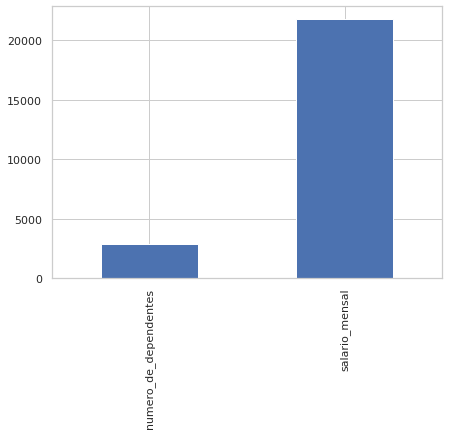

In [7]:
sns.set_style("whitegrid")
missing = df.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar();

# Identify Good Features: Information Value (IV) and Weight of Evidence (WOE)

$$WoE(i) = log\left (\frac{percent~ of~ total~ nonevents ~ in~ class~ i }{percent ~ of~ total~ events ~in ~class ~i} \right) $$<br>
$$IV = \sum_i ( (percent~ of~ nonevents ~ in~ class~ i) - (percent ~ of~ events ~in ~class ~i)) * WoE(i) $$<br>


## Data Binning:
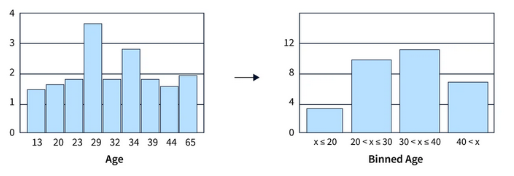

In [8]:
iv_score_dict = {}  
for col in df.columns:  
    optb = optbinning.OptimalBinning(dtype='numerical')  
    optb.fit(df[col], df['inadimplente'])  
    binning_table = optb.binning_table  
    binning_table.build()  
    iv_score_dict[col] = binning_table.iv  #calculating IVs 

iv_score_dataframe = pd.Series(iv_score_dict)  
iv_score_dataframe.sort_values(ascending=False, inplace=True)  

In [9]:
iv_score_dataframe  

util_linhas_inseguras                    1.112850
numero_vezes_passou_90_dias              0.825245
vezes_passou_de_30_59_dias               0.733272
numero_de_vezes_que_passou_60_89_dias    0.556482
idade                                    0.258262
numero_linhas_crdto_aberto               0.086096
salario_mensal                           0.079592
razao_debito                             0.074547
numero_emprestimos_imobiliarios          0.059254
numero_de_dependentes                    0.030992
inadimplente                             0.000000
dtype: float64

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.50)",63652,0.578655,59893,3759,0.059055,0.129008,0.009109,0.001138
1,"[0.50, 1.50)",19416,0.176509,18010,1406,0.072415,-0.08922,0.001461,0.000183
2,"[1.50, 2.50)",14306,0.130055,13147,1159,0.081015,-0.210762,0.006332,0.000790
3,"[2.50, inf)",9748,0.088618,8873,875,0.089762,-0.322854,0.010632,0.001323
4,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
5,Missing,2878,0.026164,2746,132,0.045865,0.3957,0.003459,0.000430
Totals,,110000,1.000000,102669,7331,0.066645,,0.030992,0.003863


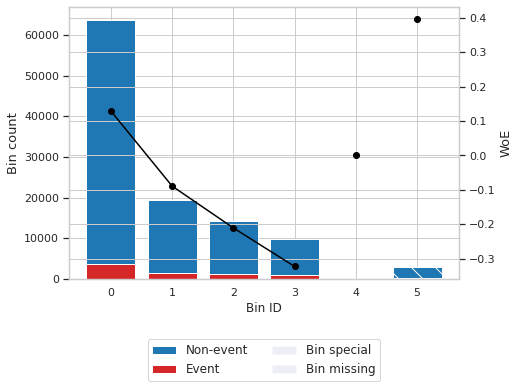

None

In [10]:
col = 'numero_de_dependentes'  
optb = optbinning.OptimalBinning(dtype='numerical')  
optb.fit(df[col], df['inadimplente'])  
binning_table = optb.binning_table  
display(binning_table.build())  
display(binning_table.plot(metric="woe"))

In [11]:
df["numero_de_dependentes_woe"] = optb.transform(df["numero_de_dependentes"], metric="woe")

In [12]:
df

,inadimplente,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes,numero_de_dependentes_woe
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0,-0.210762
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0,-0.089220
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0,0.129008
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0,0.129008
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0,0.129008
...,...,...,...,...,...,...,...,...,...,...,...,...
109995,0,0.137396,59,1,0.448912,9600.0,10,0,2,0,0.0,0.129008
109996,0,0.276964,46,0,0.491288,12224.0,19,0,4,0,4.0,-0.322854
109997,0,0.181257,43,0,0.382635,12000.0,13,0,2,0,2.0,-0.210762
109998,0,0.037699,86,0,0.248107,7000.0,14,0,2,0,1.0,-0.089220


# Removing Outliers (z-score and IQR)

In [13]:
treated_df = df.copy()

### before removing:

In [14]:
b4_neg, b4_pos = np.bincount(treated_df["inadimplente"])
b4_total = b4_neg + b4_pos
print('Total: {}\n    inadimplentes: {} ({:.2f}% of total outliers)\n'.format(
            b4_total, b4_pos, 100 * b4_pos / b4_total))

Total: 110000
    inadimplentes: 7331 (6.66% of total outliers)



### 1) salario_mensal

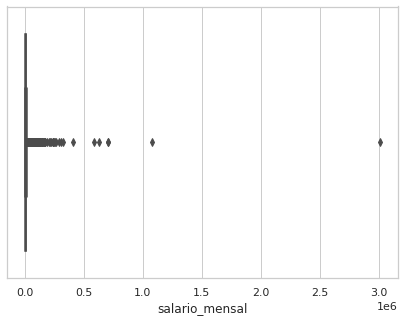

In [15]:
sns.boxplot(x=treated_df["salario_mensal"]);

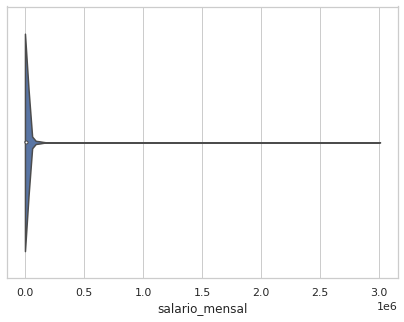

In [16]:
sns.violinplot(x=treated_df["salario_mensal"]);

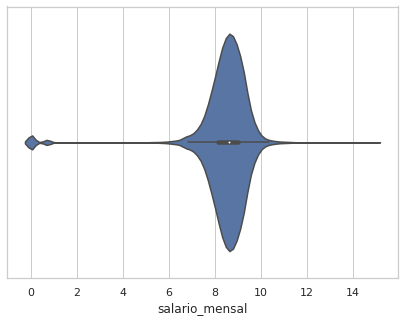

In [17]:
#target = df["salario_mensal"]
treated_df["salario_mensal"] = log1(treated_df["salario_mensal"])
#treated_df["salario_mensal"]

sns.violinplot(x=treated_df["salario_mensal"]);

Total outliers: 1693
    inadimplente: 60 (3.54% of total outliers)

total removed outliers:  1693 =  1.539090909090909 % of all data


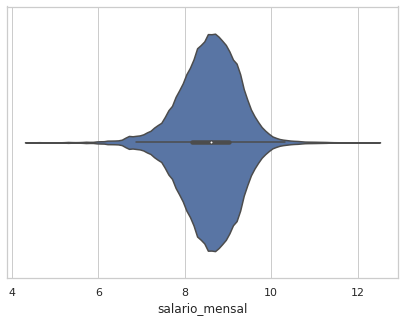

In [18]:
treated_df = drop_outliers_zscore(treated_df,"salario_mensal","inadimplente")
sns.violinplot(x=treated_df["salario_mensal"]);

### 2) razao_debito  = Dividas/Patrimônio

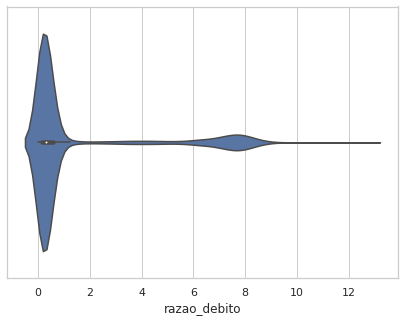

In [19]:
treated_df["razao_debito"] = log1(treated_df["razao_debito"])

sns.violinplot(data = treated_df, x="razao_debito", hue="inadimplente");

Total outliers: 124
    inadimplente: 15 (12.10% of total outliers)

total removed outliers:  124 =  0.11448936818488187 % of all data


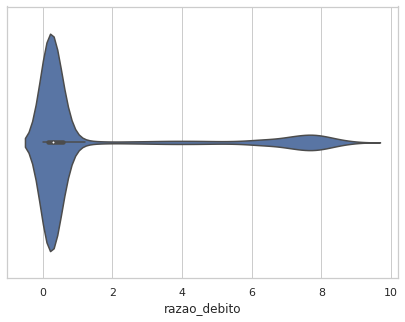

In [20]:
treated_df = drop_outliers_zscore(treated_df,"razao_debito","inadimplente")

sns.violinplot(data = treated_df, x="razao_debito", hue="inadimplente");

### 3) numero_emprestimos_imobiliarios

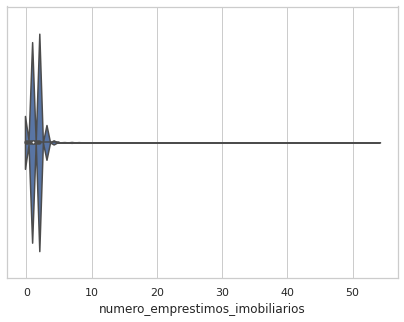

In [21]:
sns.violinplot(x=(treated_df["numero_emprestimos_imobiliarios"]));

lower:  0.0 , upper:  4.0


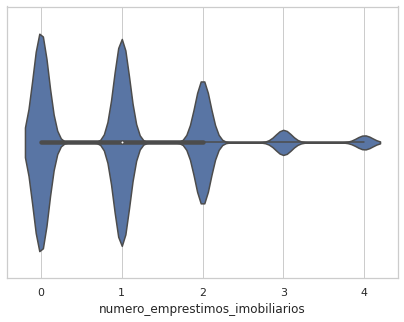

In [22]:
#removing outliers
#treated_df = drop_outliers_zscore(treated_df,"numero_emprestimos_imobiliarios","inadimplente")

lower = 0.0
#upper = q3 + 1.5 * IQR
upper = 4.0
print("lower: ",lower,", upper: ", upper)


treated_df['numero_emprestimos_imobiliarios'] = cap_outliers(treated_df['numero_emprestimos_imobiliarios'], lower, upper)



sns.violinplot(data = treated_df, x="numero_emprestimos_imobiliarios");

### 4) util_linhas_inseguras

<ul>
    <li>too many of the smaller class (inadimplente = 1) are removed by IQR and Z-score.
    </li>
    <li> this class has a very high information value, it has to be treated carefully
    </li>
</ul>

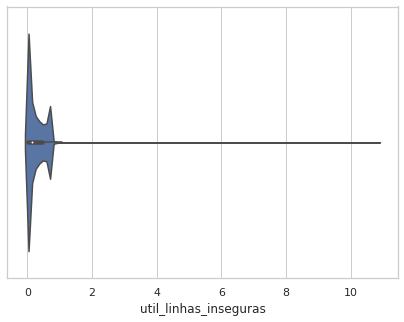

In [23]:
sns.violinplot(x=log1(treated_df["util_linhas_inseguras"]));

lower:  -0.7694265605000001 , upper:  1.0


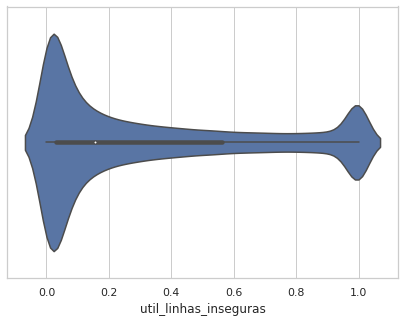

In [24]:
#removing outliers
#treated_df = drop_outliers_IQR(treated_df,"util_linhas_inseguras","inadimplente")

q1=treated_df["util_linhas_inseguras"].quantile(0.25)
q3=treated_df["util_linhas_inseguras"].quantile(0.75)
IQR=q3-q1

lower = q1 - 1.5 * IQR
#upper = q3 + 1.5 * IQR
upper = 1.0
print("lower: ",lower,", upper: ", upper)

treated_df['util_linhas_inseguras'] = cap_outliers(treated_df['util_linhas_inseguras'], lower, upper)


sns.violinplot(data = treated_df, x="util_linhas_inseguras", hue="inadimplente");

### 5) vezes_passou_de_30, 60 & 90 dias

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.50)",103836,0.943964,99035,4801,0.046236,0.387251,0.119937,0.014899
1,"[0.50, inf)",6164,0.056036,3634,2530,0.410448,-2.277284,0.705308,0.072995
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,110000,1.000000,102669,7331,0.066645,,0.825245,0.087894


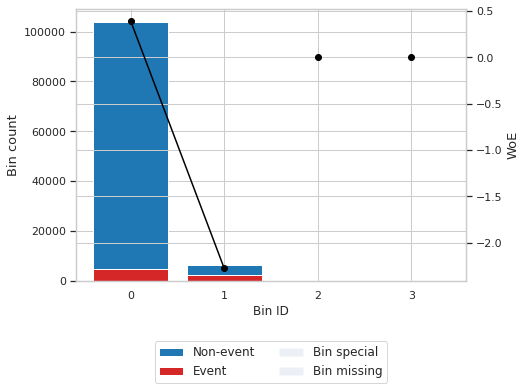

None

In [25]:
col = 'numero_vezes_passou_90_dias'  
optb = optbinning.OptimalBinning(dtype='numerical')  
optb.fit(df[col], df['inadimplente'])  
binning_table = optb.binning_table  
display(binning_table.build())  
display(binning_table.plot(metric="woe"))  

In [26]:
treated_df["numero_vezes_passou_90_dias"] = optb.transform(treated_df["numero_vezes_passou_90_dias"], metric="woe")

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.50)",104466,0.949691,99127,5339,0.051108,0.281965,0.066889,0.008334
1,"[0.50, inf)",5534,0.050309,3542,1992,0.359957,-2.063846,0.489593,0.052227
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,110000,1.000000,102669,7331,0.066645,,0.556482,0.060560


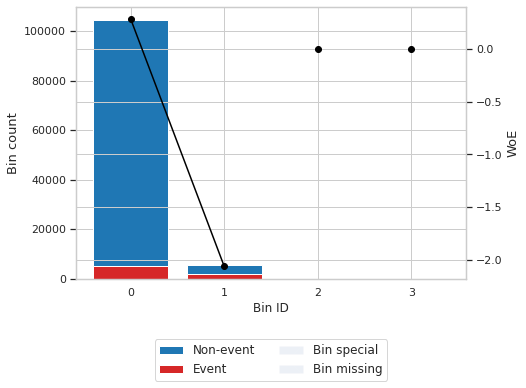

None

In [27]:
col = 'numero_de_vezes_que_passou_60_89_dias'  
optb = optbinning.OptimalBinning(dtype='numerical')  
optb.fit(df[col], df['inadimplente'])  
binning_table = optb.binning_table  
display(binning_table.build())  
display(binning_table.plot(metric="woe"))  

In [28]:
treated_df["numero_de_vezes_que_passou_60_89_dias"] = optb.transform(treated_df["numero_de_vezes_que_passou_60_89_dias"], metric="woe")

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.50)",92469,0.840627,88767,3702,0.040035,0.537743,0.193381,0.023885
1,"[0.50, 1.50)",11726,0.106600,9966,1760,0.150094,-0.905533,0.129498,0.015656
2,"[1.50, inf)",5805,0.052773,3936,1869,0.321964,-1.894637,0.410393,0.044784
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,110000,1.000000,102669,7331,0.066645,,0.733272,0.084326


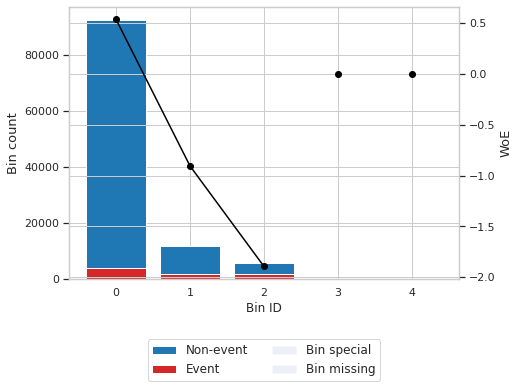

None

In [29]:
col = 'vezes_passou_de_30_59_dias'  
optb = optbinning.OptimalBinning(dtype='numerical')  
optb.fit(df[col], df['inadimplente'])  
binning_table = optb.binning_table  
display(binning_table.build())  
display(binning_table.plot(metric="woe"))  

In [30]:
treated_df["vezes_passou_de_30_59_dias"] = optb.transform(treated_df["vezes_passou_de_30_59_dias"], metric="woe")

### 5) numero_linhas_crdto_aberto

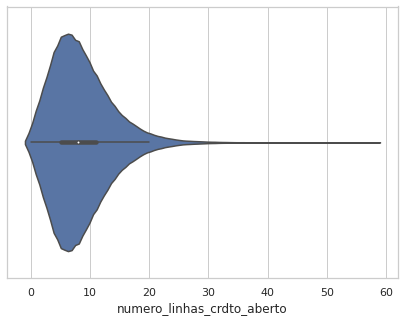

In [31]:
sns.violinplot(x=(treated_df["numero_linhas_crdto_aberto"]));

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 2.50)",9586,0.087145,8356,1230,0.128312,-0.723433,0.062499,0.007646
1,"[2.50, 3.50)",6652,0.060473,6136,516,0.077571,-0.163577,0.001737,0.000217
2,"[3.50, 4.50)",8512,0.077382,7980,532,0.062500,0.068652,0.000354,0.000044
3,"[4.50, 5.50)",9521,0.086555,8928,593,0.062283,0.072355,0.000439,0.000055
4,"[5.50, 6.50)",9988,0.090800,9430,558,0.055867,0.187894,0.002956,0.000369
5,"[6.50, 7.50)",9675,0.087955,9155,520,0.053747,0.228828,0.004173,0.000521
6,"[7.50, 8.50)",9171,0.083373,8740,431,0.046996,0.370159,0.009749,0.001212
7,"[8.50, 13.50)",30727,0.279336,28899,1828,0.059492,0.121186,0.003893,0.000486
8,"[13.50, inf)",16168,0.146982,15045,1123,0.069458,-0.044356,0.000295,0.000037
9,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000


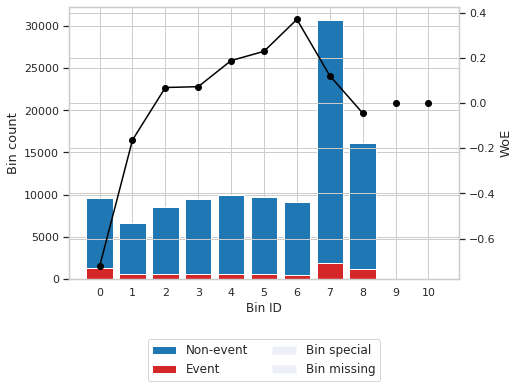

None

In [32]:
col = 'numero_linhas_crdto_aberto'  
optb = optbinning.OptimalBinning(dtype='numerical')  
optb.fit(df[col], df['inadimplente'])  
binning_table = optb.binning_table  
display(binning_table.build())  
display(binning_table.plot(metric="woe"))  

In [33]:
treated_df["linhas_crdto_woe"] = optb.transform(treated_df["numero_linhas_crdto_aberto"], metric="woe")

### Before Removing

In [34]:
print('Total: {}\n    inadimplentes: {} ({:.2f}% of total)\n'.format(
            b4_total, b4_pos, 100 * b4_pos / b4_total))

Total: 110000
    inadimplentes: 7331 (6.66% of total)



### After Removing:

In [35]:
neg, pos = np.bincount(treated_df["inadimplente"])
total = neg + pos
print('Total: {}\n    inadimplentes: {} ({:.2f}% of total)\n'.format(
            total, pos, 100 * pos / total))

print('Percent Removed: {:.2f}%\n   Percent inadimplentes Removed: {:.2f}% \n'.format(
            100 * (total - b4_total)/b4_total, 100 * (pos - b4_pos)/b4_pos))


Total: 108183
    inadimplentes: 7256 (6.71% of total)

Percent Removed: -1.65%
   Percent inadimplentes Removed: -1.02% 



# Replace the null values with preditction (Regression/Cluster mean)

In [36]:
traincols = df.columns.tolist()

In [37]:
traincols

['inadimplente',
 'util_linhas_inseguras',
 'idade',
 'vezes_passou_de_30_59_dias',
 'razao_debito',
 'salario_mensal',
 'numero_linhas_crdto_aberto',
 'numero_vezes_passou_90_dias',
 'numero_emprestimos_imobiliarios',
 'numero_de_vezes_que_passou_60_89_dias',
 'numero_de_dependentes',
 'numero_de_dependentes_woe']

### Correlations

<ul>
    <li>
        multicolinearity: is a statistical concept where several variables in a model are correlated. Indicates that collinear independent variables are not truly independent and from 
<a href="https://scikit-learn.org/stable/modules/linear_model.html#lasso">scikit learn official documentation</a>: "When features are correlated and the columns of the design matrix have an approximately linear dependence, the design matrix becomes close to singular and as a result, the least-squares (linear regression) estimate becomes highly sensitive to random errors in the observed target, producing a large variance"
    </li>
    <li> The design matrix is the name given to the matrix consisting of all feature falues $\textbf{X}$, such that, in a linear regression problem we have: <br>
        <br>
        <center>$$ \textbf{y} = \textbf{w}\textbf{X} + \textbf{b} $$</center> <br>
        Where <b>w</b> is the vector of weights that we try to predict and <b>b</b> is the bias. The Linear Regression problem can be solved by using simple matrix algebra:<br>
        <br>
        <center>$$ (\textbf{y} -  \textbf{b})\textbf{X}^{-1} = \textbf{w}  $$</center> 
        <br>
        If two or more variables (columns of the design matrix $\textbf{X}$) are colinear, then $\textbf{X}$ is singular (det($\textbf{X}) = 0$) and the problem becomes unsolvable
    </li>
</ul>

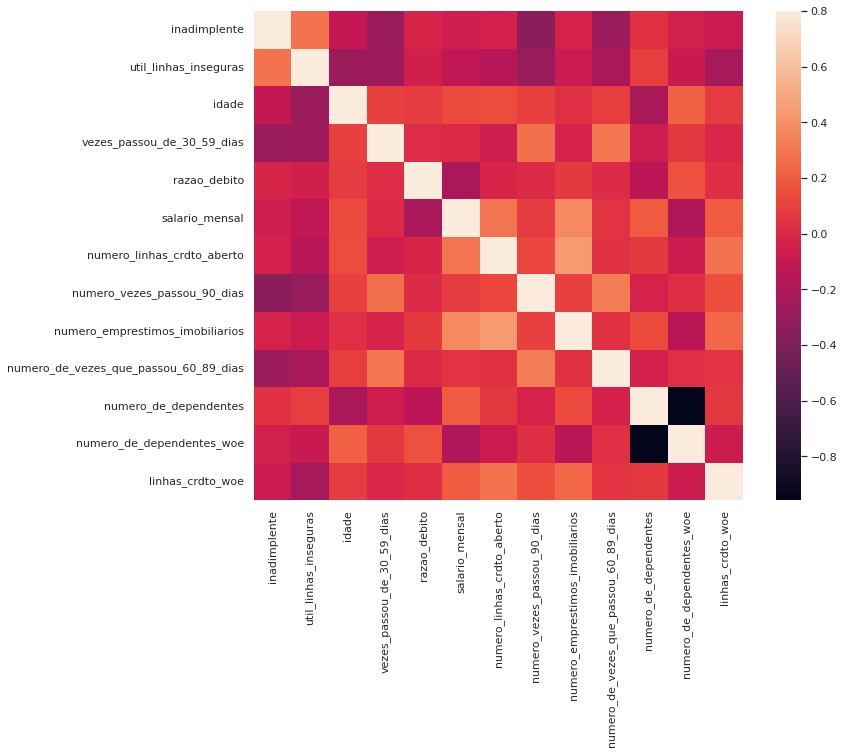

In [38]:
corrmat = treated_df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

### salario_mensal vs inadimplente

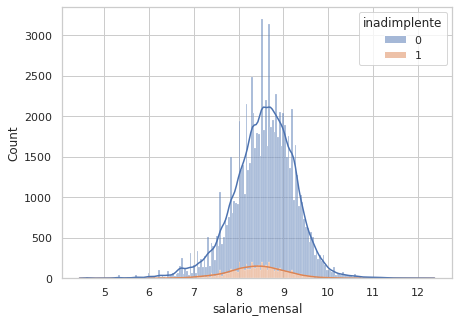

In [39]:
sns.histplot(data=treated_df, x="salario_mensal", hue="inadimplente", multiple="stack", kde=True);

In [40]:
traincols.remove("inadimplente")

### salario_mensal vs numero_de_dependentes

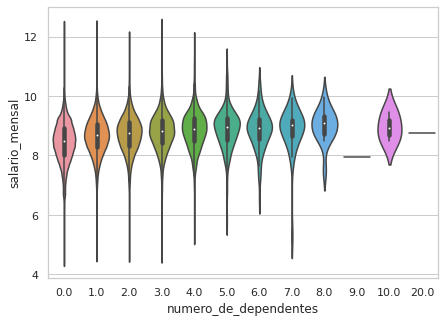

In [41]:
sns.violinplot(data=treated_df, x="numero_de_dependentes", y="salario_mensal");

In [42]:
traincols.remove("numero_de_dependentes")

### salario_mensal vs idade

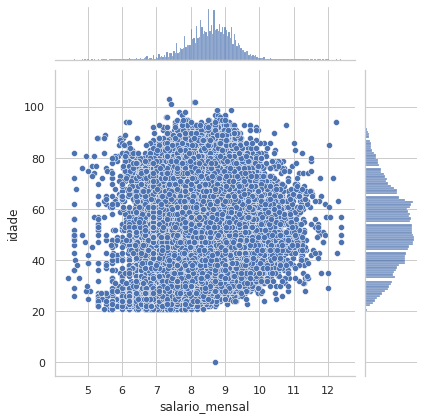

In [43]:
sns.jointplot(data = treated_df, x="salario_mensal", y="idade");

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 29.50)",6547,0.059518,5757,790,0.120666,-0.653259,0.033766,0.004147
1,"[29.50, 36.50)",11025,0.100227,9888,1137,0.103129,-0.47647,0.028009,0.003468
2,"[36.50, 43.50)",15184,0.138036,13832,1352,0.089041,-0.313999,0.015605,0.001943
3,"[43.50, 46.50)",7733,0.070300,7100,633,0.081857,-0.222019,0.003817,0.000476
4,"[46.50, 49.50)",8300,0.075455,7652,648,0.078072,-0.170567,0.002364,0.000295
5,"[49.50, 52.50)",8016,0.072873,7412,604,0.075349,-0.132117,0.001347,0.000168
6,"[52.50, 55.50)",7826,0.071145,7296,530,0.067723,-0.017194,0.000021,0.000003
7,"[55.50, 59.50)",10060,0.091455,9530,530,0.052684,0.249925,0.005130,0.000640
8,"[59.50, 62.50)",7534,0.068491,7172,362,0.048049,0.346897,0.007103,0.000883
9,"[62.50, 67.50)",10509,0.095536,10160,349,0.033210,0.731744,0.037577,0.004595


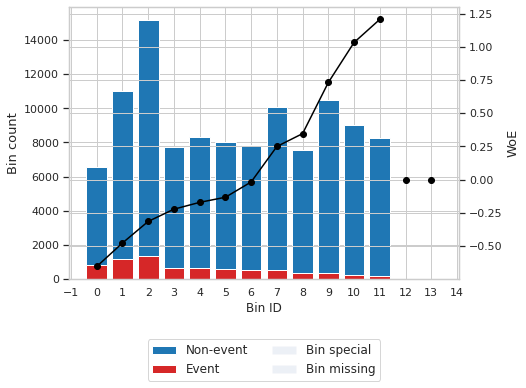

None

In [44]:
col = 'idade'  
optb = optbinning.OptimalBinning(dtype='numerical')  
optb.fit(df[col], df['inadimplente'])  
binning_table = optb.binning_table  
display(binning_table.build())  
display(binning_table.plot(metric="woe"))  

In [45]:
traincols.remove('idade')

In [46]:
traincols.append("idade_woe")
treated_df["idade_woe"] = optb.transform(treated_df["idade"], metric="woe")

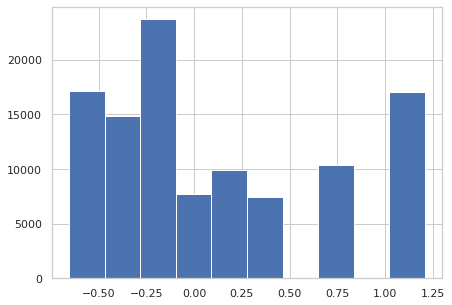

In [47]:
treated_df["idade_woe"].hist();

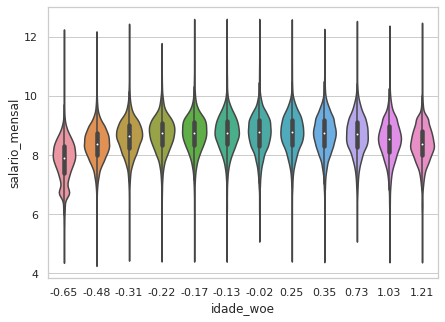

In [48]:
g = sns.violinplot(data=treated_df, x="idade_woe", y="salario_mensal")
xlabels = ['{:.2f}'.format(float(x.get_text())) for x in g.get_xticklabels()]
g.set_xticklabels(xlabels);

In [49]:
#avoid multicolinearity
traincols.remove('numero_linhas_crdto_aberto')

In [50]:
traincols

['util_linhas_inseguras',
 'vezes_passou_de_30_59_dias',
 'razao_debito',
 'salario_mensal',
 'numero_vezes_passou_90_dias',
 'numero_emprestimos_imobiliarios',
 'numero_de_vezes_que_passou_60_89_dias',
 'numero_de_dependentes_woe',
 'idade_woe']

In [51]:
train_salario_cols = [x for x in traincols if x != "salario_mensal"]

In [52]:
#scale all variables
scaler = StandardScaler()
treated_df[train_salario_cols] = scaler.fit_transform(treated_df[train_salario_cols])

### Multivariate outlier detection DBSCAN 

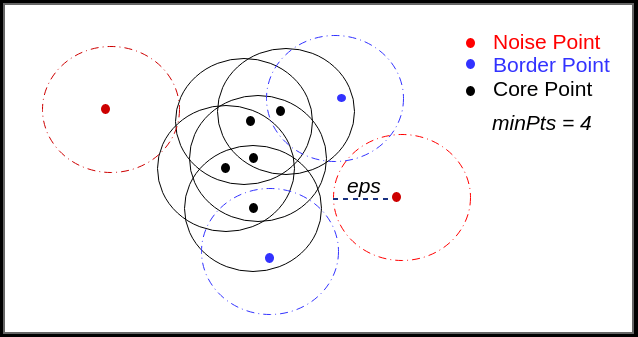

In [53]:
neigh = NearestNeighbors(n_neighbors=2, n_jobs = 4)
dbs_vars = train_salario_cols + ["inadimplente"]
nbrs = neigh.fit(treated_df[dbs_vars])
distances, indices = nbrs.kneighbors(treated_df[dbs_vars])

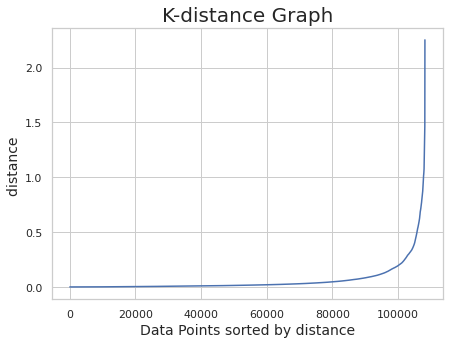

In [54]:
# K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(7,5))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('distance ',fontsize=14);

In [55]:
d = 6 * len(train_salario_cols)
eps = 1

In [56]:
dbscan_cluster = DBSCAN(eps = eps, min_samples = d, n_jobs = 4).fit(treated_df[train_salario_cols + ["inadimplente"]])
treated_df["dbs_cluster"] = dbscan_cluster.labels_
treated_df[train_salario_cols]

,util_linhas_inseguras,vezes_passou_de_30_59_dias,razao_debito,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes_woe,idade_woe
0,1.272786,-3.183204,-0.335085,0.244364,3.052115,0.230682,-1.325038,-0.617109
1,1.818610,0.419302,-0.520353,0.244364,-1.011087,0.230682,-0.571118,-0.780943
2,0.964345,-1.718280,-0.533364,-4.092256,-1.011087,0.230682,0.782540,-0.780943
3,-0.248231,0.419302,-0.551432,0.244364,-1.011087,0.230682,0.782540,-1.070336
4,1.675995,-1.718280,-0.555648,0.244364,0.004714,0.230682,0.782540,-0.525463
...,...,...,...,...,...,...,...,...
109995,-0.523721,-1.718280,-0.420460,0.244364,1.020514,0.230682,0.782540,0.223515
109996,-0.124923,0.419302,-0.409203,0.244364,3.052115,0.230682,-2.020337,-0.617109
109997,-0.398392,0.419302,-0.438744,0.244364,1.020514,0.230682,-1.325038,-0.780943
109998,-0.808588,0.419302,-0.478716,0.244364,1.020514,0.230682,-0.571118,1.927467


In [57]:
treated_df.groupby('dbs_cluster')['dbs_cluster'].count()

dbs_cluster
-1      8334
 0     31364
 1      1197
 2     11148
 3       498
       ...  
 57       66
 58       56
 59       52
 60       50
 61       48
Name: dbs_cluster, Length: 63, dtype: int64

#### Before DBSCAN

In [58]:
neg, pos = np.bincount(treated_df["inadimplente"])
total = neg + pos
print('Total: {}\n    inadimplentes: {} ({:.2f}% of total)\n'.format(
            total, pos, 100 * pos / total))

Total: 108183
    inadimplentes: 7256 (6.71% of total)



In [59]:
#treated_df = treated_df[treated_df["cluster"] != -1]

#### After DBSCAN

In [60]:
neg, pos = np.bincount(treated_df["inadimplente"])
total = neg + pos
print('Total: {}\n    inadimplentes: {} ({:.2f}% of total)\n'.format(
            total, pos, 100 * pos / total))

Total: 108183
    inadimplentes: 7256 (6.71% of total)

